In [2]:
%load_ext autoreload
%autoreload 2

import time
import geopandas as gpd
from utils import *

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

**Table of contents**<a id='toc0_'></a>    
- [Aim of the project](#toc1_1_)    
- [Introduction: theoretical background](#toc2_)    
  - [Definition of a random graph](#toc2_1_)    
  - [ Erdős-Rényi graphs](#toc2_2_)    
  - [Scale-free networks](#toc2_3_)    
    - [Diameter and fractal dimension (infinite-dimensional networks)](#toc2_3_1_)    
  - [Watts-Strogatz model](#toc2_4_)    
  - [Random graphs as a model of real networks](#toc2_5_)    
- [Discovering the datasets](#toc3_)    
    - [Brightkite](#toc3_1_1_)    
    - [Gowalla](#toc3_1_2_)    
    - [Foursquare](#toc3_1_3_)    
  - [Building the networks](#toc3_2_)    
    - [Check-ins networks](#toc3_2_1_)    
    - [Friendship network](#toc3_2_2_)    
- [Properties of the networks](#toc4_)    
  - [Average Degree](#toc4_1_)    
  - [Clustering coefficient](#toc4_2_)    
  - [Average Path Length](#toc4_3_)    
  - [Betweenness Centrality](#toc4_4_)    
  - [Download the dataframe with accurate results](#toc4_5_)    
- [Analysis of the results](#toc5_)    
    - [Distribution of Degree](#toc5_1_1_)    
  - [The Small-World Model](#toc5_2_)    
  - [Small-Worldness](#toc5_3_)    
  - [Identifying small-world networks](#toc5_4_)    
    - [A first approach: the $\sigma$ coefficient](#toc5_4_1_)    
    - [A more solid approach: the $\omega$ coefficient](#toc5_4_2_)    
      - [Lattice network construction](#toc5_4_2_1_)    
      - [Limitations](#toc5_4_2_2_)    
    - [Omega coefficient computation: standard procedure](#toc5_4_3_)    
    - [Omega coefficient computation: parallelization approach (experimental)](#toc5_4_4_)    
      - [Why experimental?](#toc5_4_4_1_)    
  - [Are our networks small-world?](#toc5_5_)    
  - [Degree distribution](#toc5_6_)    
  - [Betweenness centrality](#toc5_7_)    
  - [Clustering coefficient](#toc5_8_)    
  - [Conclusions: the omega coefficient](#toc5_9_)    
- [References](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Aim of the project](#toc0_)

<!-- Given a social network, which of its nodes are more central? `[18]` This question has been asked many times in sociology, psychology and computer science, and a whole plethora of centrality measures (a.k.a. centrality indices, or rankings) were proposed to account for the importance of the nodes of a network. 

These networks, typically generated directly or indirectly by human activity and interaction (and therefore hereafter dubbed "social"), appear in a large variety of contexts and often exhibit a surprisingly similar structure. One of the most important notions that researchers have been trying to capture in such networks is “node centrality”: ideally, every node (often representing an individual) has some degree of influence or importance within the social domain under  consideration, and one expects such importance to surface in the structure of the social network; centrality is a quantitative measure that aims at revealing the importance of a node.

Among the types of centrality that have been considered in the literature, many have to do with distances between nodes. Take, for instance, a node in an undirected connected network: if the sum of distances to all other nodes is large, the node under consideration is peripheral; this is the starting point to define Bavelas's closeness centrality, which is the reciprocal of peripherality (i.e., the reciprocal of the sum of distances to all other nodes). 

The role played by shortest paths is justified by one of the most well-known features of complex networks, the so-called **small-world phenomenon**. A small-world network is a graph where the average distance between nodes is logarithmic in the size of the network, whereas the clustering coefficient is larger (that is, neighborhoods tend to be denser) than in a random Erdős-Rényi graph with the same size and average distance. The fact that social networks (whether electronically mediated or not) exhibit the small-world property is known at least since Milgram's famous experiment and is arguably the most popular of all features of complex networks. For instance, the average distance of the Facebook graph was recently established to be just $4.74$. -->

This project aims to study the small-world phenomenon in the context of geographical social networks. We will consider a large number of centrality measures, and we will try to understand how the small-world phenomenon manifests itself in each of them. We will also try to understand how the small-world phenomenon is affected by the choice of centrality measure and how peculiar topologies of a network affects our results.

Generally speaking, a small-world network is a graph where the average distance between nodes is logarithmic in the size of the network, whereas the clustering coefficient is larger (that is, neighborhoods tend to be denser) than in a random Erdős-Rényi graph with the same size and average distance. The fact that social networks (whether electronically mediated or not) exhibit the small-world property is known at least since Milgram's famous experiment and is arguably the most popular of all features of complex networks. For instance, the average distance of the Facebook graph was recently established to be just $4.74$.

# <a id='toc2_'></a>[Introduction: theoretical background](#toc0_)

Network science aims to build models that reproduce the properties of real networks. Most networks we encounter do not have the comforting regularity of a crystal lattice or the predictable radial architecture of a spider web. 

Rather, at first inspection they look as if they were spun randomly. Random network theory embraces this apparent randomness by constructing and characterizing networks that are truly random.

From a modeling perspective a network is a relatively simple object, consisting of only nodes and links. The real challenge, however, is to decide where to place the links between the nodes so that we reproduce the complexity of a real system.

Prior to the 1960s, graph theory primarily focused on the characteristics of individual graphs. In the 1960s, Paul Erdős and Alfred Rényi introduced a systematic approach to study random graphs, which involves analyzing a collection, or ensemble, of many different graphs. 

Each graph in the ensemble is assigned a probability, and a property is said to hold with probability $P$ if the total probability of the graphs in the ensemble possessing that property is $P$, or if the fraction of graphs in the ensemble with the property is $P$. This method allows for the application of probability theory in conjunction with discrete math to study ensembles of graphs. A property is considered to hold for a class of graphs if the fraction of graphs in the ensemble without the property has zero measure, which is typically referred to as being true for "almost every" graph in the ensemble. `[2]`

## <a id='toc2_1_'></a>[Definition of a random graph](#toc0_)

Let $E_{n,N}$ stand for the collection of graphs that have $n$ designated labeled vertices $V_1, V_2, \dots, V_n$ and $N$ edges. The graphs in consideration are undirected, have no parallel edges and do not loop. Therefore, a graph within $E_{n,N}$ can be obtained by selecting $N$ from the $\binom{n}{2}$ possible connections between $V_1, V_2, \dots, V_n$. As a result, the cardinality of $E_{n,N}$ is calculated by the binomial coefficient $\binom{\binom{n}{2}}{N}$.

A random graph $\Gamma_{n,N}$ can be described as a random choice from $E_{n,N}$ such that every element of $E_{n,N}$ has an equal probability of being selected, which is $\frac{1}{\binom{\binom{n}{2}}{N}}$.

Let's take a different approach and use some probability theory. We can consider the formation of a random graph as a stochastic process. This process is defined as follows: at time $t=1$, we pick $N$ edges out of the $\binom{n}{2}$ potential connections between $V_1, V_2, \dots, V_n$, all with the same probability of being chosen; we designate this edge as $e_1$. At time $t=2$, we choose one of the $\binom{n}{2}-1$ remaining possibilities, excluding $e_1$, each with equal probability. This process continues at time $t=k+1$ where we choose one of the remaining $\binom{n}{2} - k$ possibilities, excluding $e_1, e_2, \dots, e_k$, each with probability $\frac{1}{\binom{n}{2} - k}$. The graph obtained by selecting $N$ edges in this manner is denoted as $\Gamma_{n,N}$.


> NOTE: the two definitions are equivalent, but the second one is more convenient for the study of the properties of random graphs. According to this interpretation we may study the evolution of random graphs, i.e. the step-by-step unraveling of the structure of the graph when $N$ increases.

## <a id='toc2_2_'></a>[ Erdős-Rényi graphs](#toc0_)

There are two famous groups of graphs that have been extensively analyzed: the set of all graphs with $N$ nodes and $M$ edges, referred to as $G_{N,M}$, and the set of all graphs with $N$ nodes and a connection probability of $p$ between any two nodes, denoted $G_{N,p}$. These sets, first studied by Erdős and Rényi, are alike when $M = \binom{N}{2} p$ and are therefore referred to as ER graphs if $p$ is not too close to either 0 or 1. `[2]`

A crucial aspect of a graph is its average degree, or the average number of edges attached to each node. The degree of the $i$-th node is represented by $k_i$ and the average degree is denoted by $\langle k \rangle$. Graphs with $N$ nodes and $\langle k \rangle = O(N^0)$ are called sparse graphs.

One fascinating property of the $G_{N,p}$ set is that several of its features have a corresponding threshold function, $p_t(N)$, such that the property is present with probability 0 if $p < p_t$ and with probability 1 if $p > p_t$ in the "thermodynamic limit" of $N \to \infty$. This is similar to the physical concept of a percolation phase transition.

> Check out this [impressive paper](https://arxiv.org/abs/2203.17207) that showcases properties of random graphs and their threshold functions. In this concise 6-page article, the Kahn-Kalai Conjecture is proven in a highly elegant manner.


## <a id='toc2_3_'></a>[Scale-free networks](#toc0_)

The Erdős-Rényi model `[4]` has long been the primary focus of research in the field of random graphs. However, recent studies of real-world networks have shown that the ER model does not accurately capture many of their observed properties. One such property that can be easily measured is the degree distribution, or the fraction $P(k)$ of nodes with $k$ connections (degree $k$). A well-known result `[2]` for ER networks is that the degree distribution follows a Poisson distribution, given by 

$$ P(k) = \frac{e^{z} z^k}{k!} $$

where $z = \langle k \rangle$ is the average degree `[13]`. However, measurements of the degree distribution for real networks often show that the Poisson law does not hold, instead exhibiting a scale-free degree distribution of the form

$$ P(k) = ck^{-\gamma} \quad \text{for} \quad k = m, ... , K $$

where $c \sim (\gamma -1)m^{\gamma - 1}$ is a normalization factor, and $m$ and $K$ are the lower and upper cutoffs for the degree of a node, respectively. The divergence of moments higher than $\lceil \gamma -1 \rceil$ (as $K \to \infty$ when $N \to \infty$) is responsible for many of the unusual properties attributed to scale-free networks.

It is important to note that all real-world networks are finite, so all of their moments are finite as well. The actual value of the cutoff $K$ plays a significant role, and can be approximated by noting that the total probability of nodes with $k > K$ is approximately $1/N$ `[14]`, or

$$ \int_K^\infty P(k) dk \sim \frac{1}{N} $$

This gives the result

$$ K \sim m N^{1/(\gamma -1)} $$

The degree distribution is not the only characteristic that can be used to describe a network. Other quantities, such as the degree-degree correlation (between connected nodes), spatial correlations, clustering coefficient, betweenness or centrality distribution, and self-similarity exponents, can also provide insight into the network's structure and behavior.

### <a id='toc2_3_1_'></a>[Diameter and fractal dimension (infinite-dimensional networks)](#toc0_)

> This section in only a brief introduction to the topic and a bit unrelated to the rest of the project. I decided to include it anyway since it gives a more complete picture when we will introduce the Watts-Strogatz model. However, it can be skipped without any loss of information.

Regular lattices can be viewed as networks embedded in Euclidean space of a defined dimension $d$, meaning that $n(r)$, the number of nodes within a distance $r$ from an origin, grows as $n(r) \sim r^d$ for large $r$. For fractal objects, the dimension $d$ in this relation may be a non-integer and is replaced by the fractal dimension $d_f$. `[2]`

One example of a network where these power laws do not hold is the Cayley tree, also known as the Bethe lattice, which is a regular graph of fixed degree $z$ with no loops. An infinite Cayley tree cannot be embedded in a Euclidean space of finite dimensionality. The number of nodes at level $l$ grows as $n(l) \sim (z - 1)^l$, which is faster than any power law, making Cayley trees infinite-dimensional systems.

![Photo from [2]](https://i.imgur.com/VLxR3AL.png)

_Taken from [2]_

Many random network models have locally tree-like structure (since most loops occur only when $n(l) \sim N$), and since the number of nodes grows as $n(l) \sim \langle k - 1 \rangle^l$, they are also infinite dimensional. As a result, the diameter of such graphs (i.e., the shortest path between the most distant nodes) scales as $D \sim \ln N$ `[13]`. Many properties of ER networks, including the logarithmic diameter, are also present in Cayley trees. This small diameter is in contrast to that of finite-dimensional lattices, where $D \sim N^{1/d_l}$.

Like ER networks, percolation on infinite-dimensional lattices and the Cayley tree exhibits a critical threshold $p_c = 1/(z - 1)$. For $p > p_c$, a "giant cluster" of size $N$ exists, while for $p < p_c$, only small clusters are present. At criticality ($p = p_c$) in infinite-dimensional lattices (similar to ER networks), the giant component is of size $N^{2/3}$. This result follows from the fact that percolation on lattices in dimension $d \geq d_c = 6$ is in the same universality class as infinite-dimensional percolation, where the fractal dimension of the giant cluster is $d_f = 4$, resulting in a size of the giant cluster that scales as $N^{d_f/d_c} = N^{2/3}$. The dimension $d_c$ is known as the "upper critical dimension," and this concept exists not only in percolation phenomena, but also in other physical models such as the self-avoiding walk model for polymers and the Ising model for magnetism, in both of which $d_c = 4$. `[2]`

## <a id='toc2_4_'></a>[Watts-Strogatz model](#toc0_)

In the year 1998, Watts and Strogatz presented a novel model for small-world networks in their seminal work `[3]`. This model preserves the high degree of local clustering, which is a characteristic of lattice structures where the neighbors of a node are more likely to be neighbors with each other than in random graphs. The model achieves a reduction in the diameter of the network to $D \sim \ln N$ by randomly rewiring a fraction $\varphi$ of the links in a regular lattice to connect to distant nodes. The rewiring procedure is based on a probability $p$ assigned to each edge. If an edge is selected for rewiring, it is substituted with a new edge chosen at random with uniform probability. The resulting network is characterized by $N$ nodes, $k$ nearest neighbors, and an average distance of $\log(N)/\log(k)$.

More details on the Watts-Strogatz model can be found in `[3]`.

## <a id='toc2_5_'></a>[Random graphs as a model of real networks](#toc0_)

Many physical and man-made systems can be represented as networks, which consist of objects and the interactions between them. Some examples include computer networks, such as the Internet, and logical networks, including the links between web pages and email networks, where the presence of an individual's address in another person's address book is represented by a link. Additionally, social interactions in populations or work relationships and movements of a system in a configuration space can also be described using a network. These examples, along with many others, possess a graph structure that can be studied. Although many of these networks exhibit some ordered structure, such as cluster and group formation, geographical or geometrical considerations, or specific properties, most of them possess complex and random structures that deviate from regular lattices. As a result, it is often assumed, with caution, that they share properties with random graph models.

Scale-free networks can be considered as a generalization of Erdős-Rényi (ER) networks. When $\gamma > 4$, the properties of scale-free networks, such as distances, optimal paths, and percolation, are similar to those in ER networks. Conversely, when $\gamma < 4$, these properties exhibit anomalous behavior due to the strong heterogeneity in the degrees of nodes, which disrupts the node-to-node translational homogeneity (symmetry) present in classical homogeneous networks such as lattices, Cayley trees, and ER graphs. `[2]`

---

In this section of the notebook, we'll delve into the technical aspect of analyzing the properties of real-world networks that were discussed previously. We will try to make as much usage as possibile of the [networkx](https://networkx.org/) library. However, some algorithms required manual implementation and can be found in the `utils.py` module that I strongly recommend to read.

The computations were executed on an Arch Linux machine with a AMD Ryzen 5 2600 processor (6 cores and 12 threads) and 16 GB of RAM. The code was written in Python 3.10.9, and the required packages can be installed by executing the following command in the terminal:

```bash
pip3 install -r requirements.txt
```

I have made efforts to ensure that the code is widely compatible, but I was unable to test it on a Windows or MacOS machine since I have neither of those operating systems installed on any of my personal devices. In the event that any issues are encountered, please inform me so I can work towards resolving them.

# <a id='toc3_'></a>[Discovering the datasets](#toc0_)

To perform our analysis, we will use the following datasets:

- **Brightkite**
- **Gowalla**
- **Foursquare**

We can download the datasets using the function `download_dataset` from the `utils` module. It will download the datasets in the `data` folder, organized in sub-folders in the following way:

```
data
├── brightkite
│   ├── brightkite_checkins_full.txt
│   └── brightkite_friends_edges.txt
├── foursquare
│   ├── foursquare_checkins_full.txt
│   ├── foursquare_friends_edges.txt
│   └── raw_POIs.txt
└── gowalla
    ├── gowalla_checkins_full.txt
    └── gowalla_friends_edges.txt
```

For further details about the function below, please refer to the `utils` module.

> **NOTE:** the Stanford servers tends to be slow, so it may take a few minutes to download them.

In [2]:
# this is a long and boring function to automatically download, extract, rename and save the datasets in a clean way. If you want to have a deeper look at the code, you can find it in utils.py

download_datasets() # it takes about 3-4 minutes to download and extract the datasets with a fiber connection

## If you want to run it again, delete the data folder and run the function again

Created data folder
Created brightkite folder
Created gowalla folder
Created foursquare folder


Downloading...
From: https://drive.google.com/uc?id=1PNk3zY8NjLcDiAbzjABzY5FiPAFHq6T8
To: /home/luke/github/small-worlds/data/foursquare/foursquare_full.zip
100%|██████████| 2.68G/2.68G [02:03<00:00, 21.8MB/s]


Unzipping loc-brightkite_edges.txt.gz...
Unzipping loc-brightkite_totalCheckins.txt.gz...
Unzipping loc-gowalla_edges.txt.gz...
Unzipping loc-gowalla_totalCheckins.txt.gz...
Unzipping foursquare_full.zip...
Archive:  /home/luke/github/small-worlds/data/foursquare/foursquare_full.zip
   creating: /home/luke/github/small-worlds/data/foursquare/dataset_WWW2019/
  inflating: /home/luke/github/small-worlds/data/foursquare/dataset_WWW2019/raw_Checkins_anonymized.txt  
  inflating: /home/luke/github/small-worlds/data/foursquare/dataset_WWW2019/.DS_Store  
   creating: /home/luke/github/small-worlds/data/foursquare/__MACOSX/
   creating: /home/luke/github/small-worlds/data/foursquare/__MACOSX/dataset_WWW2019/
  inflating: /home/luke/github/small-worlds/data/foursquare/__MACOSX/dataset_WWW2019/._.DS_Store  
  inflating: /home/luke/github/small-worlds/data/foursquare/dataset_WWW2019/raw_POIs.txt  
  inflating: /home/luke/github/small-worlds/data/foursquare/dataset_WWW2019/dataset_WWW_friendship_

### <a id='toc3_1_1_'></a>[Brightkite](#toc0_)

[Brightkite](http://www.brightkite.com/) was a location-based social networking service that allowed users to share their locations by checking in. The friendship network data was collected using the Brightkite public API. There are two datasets available for analysis: 

- `brightkite_checkins_full.txt`, which contains check-in data in the form of a tab-separated file with five columns: `user id`, `check-in time`, `latitude`, `longitude`, and `location id`
  
- `brightkite_friends_edges.txt`, which is a tab-separated file with two columns containing user IDs and representing the friendship network in the form of a graph edge list. 

The `brightkite_checkins_full.txt` dataset must be converted into a graph before it can be analyzed properly, while the `brightkite_friends_edges.txt` dataset is already in a usable form for graph analysis.

Let's have a more clear view of where our data have been generated

Number of unique users:  35538


<AxesSubplot: >

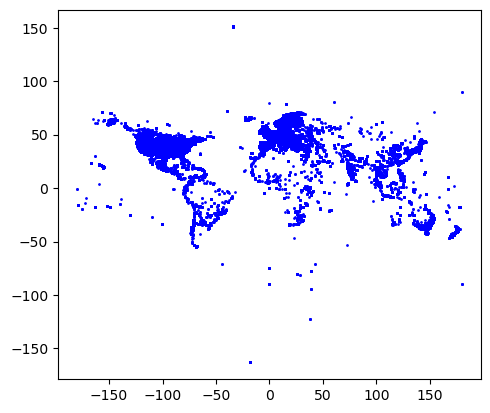

In [3]:
# It takes about 2 minutes to run this block

df_brighkite = pd.read_csv(os.path.join('data', 'brightkite', 'brightkite_checkins_full.txt'), 
                sep='\t', 
                header=None,
                names=['user id', 'check-in time', 'latitude', 'longitude', 'location id'],
                parse_dates=['check-in time'],
                engine='pyarrow') # multi-threaded engine (sometimes it's faster)

# take only data from 2009
df_brighkite = df_brighkite[df_brighkite['check-in time'].dt.year == 2009]

# convert the dataframe to geopandas dataframe
gdf_brightkite = gpd.GeoDataFrame(df_brighkite, geometry=gpd.points_from_xy(df_brighkite.longitude, df_brighkite.latitude))

# plot the geopandas dataframe
print("Number of unique users: ", len(df_brighkite['user id'].unique()))
gdf_brightkite.plot(marker='o', color='blue', markersize=1)

Familiar shape, isn't it? As we can see there are ~35k nodes, a bit too much for our future computation. Let's take a subset, like Europe!

Number of unique users in Europe:  8525


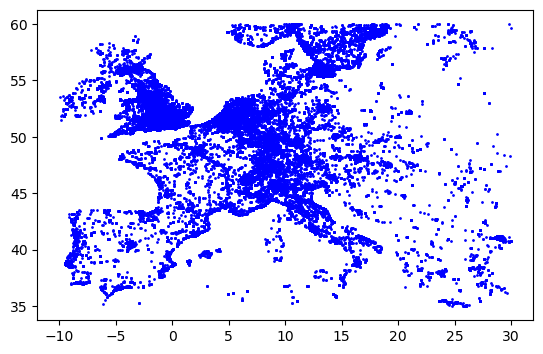

In [4]:
gdf_brightkite = gdf_brightkite[gdf_brightkite['latitude'] < 60]
gdf_brightkite = gdf_brightkite[gdf_brightkite['latitude'] > 35]
gdf_brightkite = gdf_brightkite[gdf_brightkite['longitude'] < 30]
gdf_brightkite = gdf_brightkite[gdf_brightkite['longitude'] > -10]

gdf_brightkite.plot(marker='o', color='blue', markersize=1)

# update the pandas dataframe with the new values
df_brighkite = gdf_brightkite
print("Number of unique users in Europe: ", len(df_brighkite['user id'].unique()))

# remove from memory the geopandas dataframe, it was only used for plotting
del gdf_brightkite

Perfect! Now we can create a new .txt file, only with the information that we need

In [5]:
# update the file with the new values. Drop the columns that are not needed
df_brighkite.to_csv(
    os.path.join('data', 'brightkite', 'brightkite_checkins.txt'), 
    sep='\t', 
    header=False, 
    index=False, 
    columns=['user id', 'location id'])

# I prefer not to delete the full dataset, since it's bad practice in my opinion. If you want to delete it, uncomment the following line

# os.remove(os.path.join('data', 'brightkite', 'brightkite_checkins_full.txt'))

### <a id='toc3_1_2_'></a>[Gowalla](#toc0_)

Gowalla is a location-based social networking website where users share their locations by checking-in. The friendship network is undirected and was collected using their public API. As for Brightkite, we will work with two different datasets. This is how they look like after being filtered by the `download_dataset` function:

- `data/gowalla/gowalla_checkins.txt`: the checkins,  a tsv file with 5 columns: `user id`, `check-in time`, `latitude`, `longitude`, `location id`

- `data/gowalla/gowalla_friends_edges.txt`: the friendship network, a tsv file with 2 columns of users ids. This file it's in the form of a graph edge list. 


Let's have a more clear view of where our data have been generated

Number of unique users:  12611


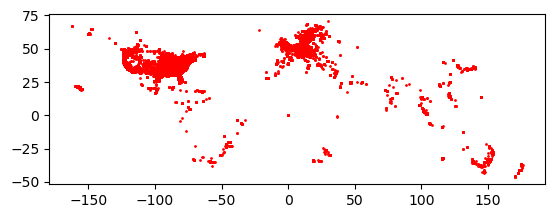

In [6]:
df_gowalla = pd.read_csv(os.path.join('data', 'gowalla', 'gowalla_checkins_full.txt'),
                            sep='\t', 
                            header=None,
                            names=['user id', 'check-in time', 'latitude', 'longitude', 'location id'],
                            parse_dates=['check-in time'],
                            engine='pyarrow')

# take only data from 2009
df_gowalla = df_gowalla[df_gowalla['check-in time'].dt.year == 2009]

# convert the dataframe to geopandas dataframe
gdf_gowalla = gpd.GeoDataFrame(df_gowalla, geometry=gpd.points_from_xy(df_gowalla.longitude, df_gowalla.latitude))

# plot the geopandas dataframe
gdf_gowalla.plot(marker='o', color='red', markersize=1)
print("Number of unique users: ", len(df_gowalla['user id'].unique()))

This is still a bit too much, let's take a subset of the European area

Number of unique users in the EU area:  3718


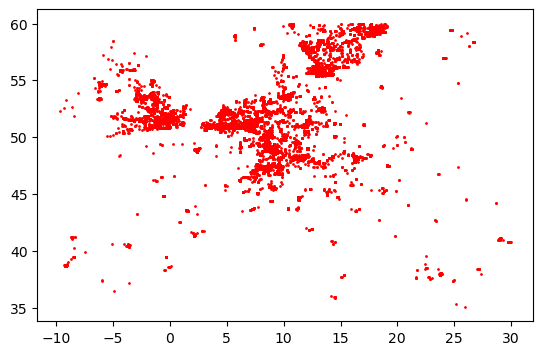

In [7]:
gdf_gowalla = gdf_gowalla[gdf_gowalla['latitude'] < 60]
gdf_gowalla = gdf_gowalla[gdf_gowalla['latitude'] > 35]
gdf_gowalla = gdf_gowalla[gdf_gowalla['longitude'] < 30]
gdf_gowalla = gdf_gowalla[gdf_gowalla['longitude'] > -10]

gdf_gowalla.plot(marker='o', color='red', markersize=1)

df_gowalla = gdf_gowalla
print("Number of unique users in the EU area: ", len(df_gowalla['user id'].unique()))

# remove from memory the geopandas dataframe, it was only used for plotting
del gdf_gowalla

Perfect! Now we can create a new .txt file, only with the information that we need

In [8]:
# update the file with the new values. Drop the columns that are not needed
df_gowalla.to_csv(
    os.path.join('data', 'gowalla', 'gowalla_checkins.txt'), 
    sep='\t', 
    header=False, 
    index=False, 
    columns=['user id', 'location id'])

# os.remove(os.path.join('test_data', 'brightkite', 'brightkite_checkins_full.txt'))

### <a id='toc3_1_3_'></a>[Foursquare](#toc0_)

[Foursquare](https://foursquare.com/) is a location-based social networking website where users share their locations by checking-in. This dataset includes long-term (about 22 months from Apr. 2012 to Jan. 2014) global-scale check-in data collected from Foursquare, and also two snapshots of user social networks before and after the check-in data collection period (see more details in the reference paper `[15]`). We will work with three different datasets:

- `foursquare_checkins_full.txt`: a tsv file with 4 columns: `User ID`, `Venue ID`, `UTC time`, `Timezone offset in minutes`  

- `foursquare_friends_edges.txt`: the friendship network, a tsv file with 2 columns of users ids. This is in the form of a graph edge list. 

- `raw_POIs.txt`: the POIS, a tsv file with 5 columns: `Venue ID`, `Latitude`, `Longitude`, `Venue category name`, `Country code (ISO)`.

--- 

The check-in dataset in consideration is by fare the bigger of this study, it has `22809624` check-ins made by `114324` users at `3820891` venues. Additionally, the social network data consists of `607333` friendships. As previously indicated, the need for sub-sampling becomes a must due to the size of the full network. In this instance, we shall restrict our analysis to data generated in Italy in the year 2012. Given the substantial size of the full network, plotting it would likely result in an unfavorable outcome, as the available RAM may become exhausted and the kernel may be forced to terminate the process.

Number of unique users in Italy:  2555


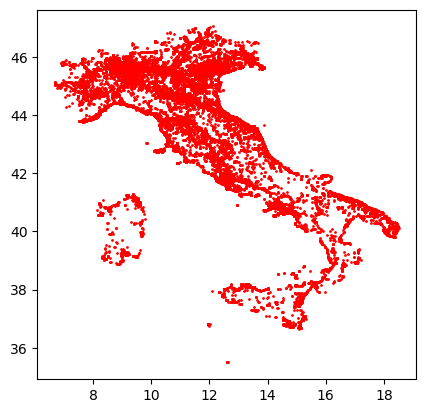

In [9]:
df_foursquare_POIS = pd.read_csv(os.path.join('data', 'foursquare', 'raw_POIs.txt'), 
                                    sep='\t',
                                    header=None,
                                    names=['venue id', 'latitude', 'longitude', 'venue category name', 'ISO code'],
                                    dtype={'venue id': str, 'latitude': float, 'longitude': float, 'venue category name': str, 'ISO code': str},
                                    engine='c')

df_foursquare_checkins = pd.read_csv(os.path.join('data', 'foursquare', 'foursquare_checkins_full.txt'),
                                        sep='\t',
                                        header=None,
                                        names=['user id', 'venue id', 'UTC time', 'offset'],
                                        dtype={'user id': str, 'venue id': str, 'UTC time': str, 'offset': int},
                                        engine='c')

# Take only data with IT ISO code
df_foursquare_POIS = df_foursquare_POIS[df_foursquare_POIS['ISO code'] == 'IT']

# Take only the checkins that are in the POIs (filtered by ISO code) and viceversa
df_foursquare_checkins = df_foursquare_checkins[df_foursquare_checkins['venue id'].isin(df_foursquare_POIS['venue id'])]
df_foursquare_POIS = df_foursquare_POIS[df_foursquare_POIS['venue id'].isin(df_foursquare_checkins['venue id'])]

# Convert to datetime
df_foursquare_checkins['UTC time'] = pd.to_datetime(df_foursquare_checkins['UTC time'])

# Take only the data from 2012
df_foursquare_checkins = df_foursquare_checkins[df_foursquare_checkins['UTC time'].dt.year == 2012]

# convert the dataframe to geopandas dataframe
gdf_foursquare_POIS = gpd.GeoDataFrame(df_foursquare_POIS, geometry=gpd.points_from_xy(df_foursquare_POIS.longitude, df_foursquare_POIS.latitude))

# plot the geopandas dataframe
gdf_foursquare_POIS.plot(marker='o', color='red', markersize=1)
print('Number of unique users in Italy: ', len(df_foursquare_checkins['user id'].unique()))

# delete from memory the geo dataframe, it was only used for plotting
del gdf_foursquare_POIS

In [10]:
df_foursquare_checkins.to_csv(
    os.path.join('data', 'foursquare', 'foursquare_checkins.txt'),
    sep='\t',
    header=False,
    index=False,
    columns=['user id', 'venue id'])

# os.remove(os.path.join('test_data', 'foursquare', 'foursquare_checkins_full.txt'))

## <a id='toc3_2_'></a>[Building the networks](#toc0_)

### <a id='toc3_2_1_'></a>[Check-ins networks](#toc0_)

The construction of networks for the three datasets will be accomplished by representing them as an undirected graph $M = (V, E)$, with $V$ denoting the set of nodes and $E$ denoting the set of edges. The nodes will correspond to the users and the edges will indicate the presence of at least one instance where two individuals visited the same location.

Since the check-ins files of the three datasets are not in the format of a graph edge list, it is necessary to manipulate them.

In [11]:
def count_lines_and_unique_elements(file):
    df = pd.read_csv(file, sep='\t', header=None)
    print('Number of lines: ', len(df))
    print('Number of unique elements: ', len(df[0].unique()))

gowalla_path = os.path.join('data', 'gowalla', 'gowalla_checkins.txt')
brightkite_path = os.path.join('data', 'brightkite', 'brightkite_checkins.txt')
foursquare_path = os.path.join('data', 'foursquare', 'foursquare_checkins.txt')

_ = [gowalla_path, brightkite_path, foursquare_path]

for path in _:
    print(path.split(os.sep)[-2])
    count_lines_and_unique_elements(path)
    print()

gowalla
Number of lines:  83269
Number of unique elements:  3718

brightkite
Number of lines:  391220
Number of unique elements:  8525

foursquare
Number of lines:  125076
Number of unique elements:  2555



We want to construct a graph from an edge list. To accomplish this, we will examine the users that have visited each venue. Subsequently, we will establish an edge between every pair of users who have visited the same venue, while avoiding duplications. This process can be executed efficiently (algorithmically speaking) in Python, although it may entail a slow computational time due the nature of the language itself. The methodology for creating this graph is illustrated below in the Python code snippet.

```python
# let df be the dataframe ["user_id", "venue_id"] of the checkins

venues_users = df.groupby("venue_id")["user_id"].apply(set)

        for users in venues_users:
            for user1, user2 in combinations(users, 2):
                G.add_edge(user1, user2)
```

The code makes use of a dataframe, `df`, which contains the `user_id` and `venue_id` information for each check-in. The code first groups the check-ins by the `venue_id` and applies a set function to the `user_id` values. Then, the code iterates through each set of users that visited the same venue and adds an edge between every pair of users.

I have included a function in the `utils.py` module that performs this process automatically. The function, named `create_graph_from_checkins`, takes as input the name of the data set and returns a graph object in the NetworkX library. By default, this function also writes the edge list to a file in the respective dataset folder. The available options for the input dataset are "brightkite", "gowalla", and "foursquare". An example of how to use this function is shown below.

In [3]:
G_brighkite_checkins = create_graph_from_checkins('brightkite', create_file=True)
G_brighkite_checkins.name = 'Brightkite Checkins Graph'

G_gowalla_checkins = create_graph_from_checkins('gowalla', create_file=True)
G_gowalla_checkins.name = 'Gowalla Checkins Graph'

G_foursquare_checkins = create_graph_from_checkins('foursquare', create_file=True)
G_foursquare_checkins.name = 'Foursquare Checkins Graph'


Creating the graph for the dataset brightkite...


100%|██████████| 84831/84831 [00:00<00:00, 269549.94it/s]


Done! The graph has 292973 edges and 6493 nodes

Creating the graph for the dataset gowalla...


100%|██████████| 31095/31095 [00:00<00:00, 346067.81it/s]


Done! The graph has 62790 edges and 3073 nodes

Creating the graph for the dataset foursquare...


100%|██████████| 40650/40650 [00:00<00:00, 148202.44it/s]


Done! The graph has 246702 edges and 2324 nodes


### <a id='toc3_2_2_'></a>[Friendship network](#toc0_)


We want to construct a friendship graph that represents the relationships between users in a social network. The concept of friendship will be modeled in accordance with the paradigm of Facebook, as opposed to Twitter. Consequently, the graph will be undirected and edges will not be weighted. Moreover, it is imperative to note that a user cannot be friends with himself, nor can he be friends with another user if the latter is not friends with him.

The friendship graph will be generated using the function `create_friendships_graph` located in the `utils.py` module. The function takes as input the name of the dataset and returns a networkx graph object. By default, the edge list will also be written to a file within the respective dataset folder. The available options for the input dataset are _brightkite_, _gowalla_, and _foursquare_.

> It is worth mentioning that this function has been implemented in a manner that does not require the checkins graph to be loaded in memory. Instead, it utilizes the edge list file. This was done with the consideration that some users may only perform analysis on the friendship network, and as such, there is no need to load the checkins graph and waste memory. 

In [4]:
G_brighkite_friends = create_friendships_graph('brightkite', create_file=True)
G_brighkite_friends.name = 'Brightkite Friendship Graph'

G_gowalla_friends = create_friendships_graph('gowalla', create_file=True)
G_gowalla_friends.name = 'Gowalla Friendship Graph'

G_foursquare_friends = create_friendships_graph('foursquare', create_file=True)
G_foursquare_friends.name = 'Foursquare Friendship Graph'

Created the graph for the dataset brightkite with 14690 edges and 5420 nodes
Created the graph for the dataset gowalla with 5548 edges and 2294 nodes
Created the graph for the dataset foursquare with 5323 edges and 1397 nodes


The networks under investigation are more abstract than previously observed networks as they lack geographical information. To gain insight into their structure, we can use a Newtonian gravity model to examine the interactions between the nodes. Given that the plot will be presented on a web page in the form of an html file, it is necessary to sample the network extensively. Although this process will not provide an exact representation of the network, it will provide a general understanding of the distribution of nodes. To achieve this, we will use a subsample of approximately 1000 nodes from the largest connected component. 

This task can be performed through the `visualize_graphs` function in the `utils.py` module. The function requires as inputs a networkx graph object, a `k` percentage of nodes to remove, and a `connected` boolean that specifies whether to only consider the largest connected component. By default, `k` is set to obtain a subsample of around 1000 nodes, and connected is set to `True`. The function outputs an html file that can be opened in a web browser. All files will be downloaded to the `html_graphs` folder.

In [5]:
friendships_graph = [G_brighkite_friends, G_gowalla_friends, G_foursquare_friends]

for graph in friendships_graph:
    visualize_graphs(graph, k = None, connected=True)

# if we are curios about the checkins graphs, nothing prevents us to visualize them. Just uncomment the following lines. However, this has not been tested properly, so we might encounter some slow-downs with the checkins graphs

# checkins_graph = [G_brighkite_checkins, G_gowalla_checkins, G_foursquare_checkins]
# for graph in checkins_graph:
#     visualize_graphs(graph, k = 0.7, connected=True)

The graph has been saved in the folder html_graphs with the name brightkite_friendship_graph.html
The graph has been saved in the folder html_graphs with the name gowalla_friendship_graph.html
The graph has been saved in the folder html_graphs with the name foursquare_friendship_graph.html


On a unix environment, if firefox is installed, we can visualize them by running the following command:

```bash
firefox html_graphs/*.html
```

Otherwise, I have already made this computations and the results can be visualized following the links below

- [Brightkite](https://lukefleed.xyz/graphs/brightkite_friendship_graph.html)
- [Gowalla](https://lukefleed.xyz/graphs/gowalla_friendship_graph.html)
- [Foursquare](https://lukefleed.xyz/graphs/foursquare_friendship_graph.html)

> **EXTRA:** If you want to see a visualization of a complete different graph, here you can check che collaboration network of the actors on the IMDb website. It has very distinct communities and clusters. Only actors with more then 100 movies have been considered. Click [here](https://lukefleed.xyz/graph/imdb-graph.html) to see the visualization.

# <a id='toc4_'></a>[Properties of the networks](#toc0_)

In order to effectively visualize the outcomes of our analysis, we will construct a dataframe that encapsulates all the information retrieved from the networks under examination. It should be noted that the full networks, despite having undergone filtering, are still substantial in size, which results in prolonged execution times for the functions that we are going to use. To mitigate this issue, we will take sub-samples. Keep in mind that the accuracy of the results is proportional to the size of the sample utilized.

In light of these considerations, I recommend conducting an initial review of the notebook with higher values of the sampling rate (the default ones) to expedite the display of the results and gain an understanding of the functionality of the implemented functions. At the end of this section I provided a link to my GitHub repository, where the results obtained through lower sampling rates can be downloaded. This approach allows for a preliminary assessment of the functionality of the functions with mock-networks, before proceeding with the analysis using the more precise results that necessitate longer computation times.

In [6]:
checkins_graphs = [G_brighkite_checkins, G_gowalla_checkins, G_foursquare_checkins]
friendships_graph = [G_brighkite_friends, G_gowalla_friends, G_foursquare_friends]

graphs_all = checkins_graphs + friendships_graph

In [16]:
analysis_results = pd.DataFrame(columns=['Graph', 'Number of Nodes', 'Number of Edges', 'Average Degree', 'Average Clustering Coefficient', 'log N', 'Average Shortest Path Length', 'betweenness centrality', 'omega-coefficient'], index=None)

for graph in graphs_all:
    analysis_results = analysis_results.append(
        {'Graph': graph.name, 
        'Number of Nodes': graph.number_of_nodes(), 
        'log N': np.log(graph.number_of_nodes()),
        'Number of Edges': graph.number_of_edges()}, 
        ignore_index=True)

analysis_results

Graph Number of Nodes Number of Edges Average Degree  \
0    Brightkite Checkins Graph            6493          292973            NaN   
1       Gowalla Checkins Graph            3073           62790            NaN   
2    Foursquare Checkins Graph            2324          246702            NaN   
3  Brightkite Friendship Graph            1500            1167            NaN   
4     Gowalla Friendship Graph            1500            2318            NaN   
5  Foursquare Friendship Graph            1397            5323            NaN   

  Average Clustering Coefficient     log N Average Shortest Path Length  \
0                            NaN  8.778480                          NaN   
1                            NaN  8.030410                          NaN   
2                            NaN  7.751045                          NaN   
3                            NaN  7.313220                          NaN   
4                            NaN  7.313220                          NaN   
5                            NaN  7.242082                          NaN   

  betweenness centrality omega-coefficient  
0                    NaN               NaN  
1                    NaN               NaN  
2                    NaN               NaN  
3                    NaN               NaN  
4                    NaN               NaN  
5                    NaN               NaN

## <a id='toc4_1_'></a>[Average Degree](#toc0_)

The concept of degree refers to the number of links that are connected to a particular node. While the average degree is a basic measure, it is not deemed to be of significant utility for our upcoming analysis, thus it will not be given extensive consideration. In contrast, the degree distribution, represented by $P(k)$, which represents the proportion of nodes that have a degree of $k$, is deemed to be a more meaningful metric. The literature on network analysis indicates that real-world networks often do not adhere to the Poisson degree distribution that is predicted by the ER model. Instead, many networks exhibit a degree distribution with a long-tailed, power-law distribution, such that $P(k) \sim k^{-\gamma}$, with a value of $\gamma$ typically ranging from $2$ to $3$.

In [17]:
for G in graphs_all:
    avg_deg = np.mean([d for n, d in G.degree()])
    analysis_results.loc[analysis_results['Graph'] == G.name, 'Average Degree'] = avg_deg

analysis_results[['Graph', 'Average Degree']]

Graph Average Degree
0    Brightkite Checkins Graph      90.242723
1       Gowalla Checkins Graph      40.865604
2    Foursquare Checkins Graph      212.30809
3  Brightkite Friendship Graph          1.556
4     Gowalla Friendship Graph       3.090667
5  Foursquare Friendship Graph       7.620616

## <a id='toc4_2_'></a>[Clustering coefficient](#toc0_)

The Clustering Coefficient `[2]` refers to the concept of communities represented by local structures in a network. This notion is generally related to the number of triangles present in the network and considered high when two nodes sharing a common neighbor exhibit a high probability of being connected. There are two commonly accepted definitions of clustering: the global definition and the local definition.

The global definition of clustering is expressed mathematically as follows:

$$ C = \frac{3 \times \text{the number of triangles in the network}}{\text{the number of connected triples of vertices}}$$

where a “connected triple” represents a vertex with edges connecting to an unordered pair of other vertices.

The local definition of clustering, on the other hand, is based on the average of the clustering coefficient of individual nodes. The clustering coefficient for a single node is defined as the fraction of pairs of its linked neighbors to the total number of pairs of its neighbors. This relationship can be mathematically represented as:

$$ C_i = \frac{\text{the number of triangles connected to vertex }i}{\text{the number of triples centered on vertex } i} $$

For vertices with degree $0$ or $1$, the numerator and denominator of the equation are both equal to zero, and in such cases, $C_i = 0$. The clustering coefficient for the whole network is then obtained as the average of $C_i$ as expressed in the equation below:

$$ C = \frac{1}{n} \sum_{i} C_i $$

It is important to note that the clustering coefficient is always in the range of $0 \leq C \leq 1$. In random graph models such as the ER model and the configuration model, the clustering coefficient is low and decreases to zero as the network size increases. This is also observed in many growing network models. However, many real-world networks exhibit a high clustering coefficient that remains constant even for large network sizes.

> This phenomenon led to the introduction of the small-world model `[3]`, which combines the properties of a regular lattice with high clustering and a random graph.

---

The library `networkx` provides a function to compute the clustering coefficient of a graph.

In [18]:
for graph in graphs_all:
    print("\nComputing average clustering coefficient for the {}...".format(graph.name))
    start = time.time()
    avg_clustering = nx.average_clustering(graph)
    end = time.time()
    print("\tAverage clustering coefficient: {}".format(avg_clustering))
    print("\tCPU time: " + str(round(end-start,1)) + " seconds")
    analysis_results.loc[analysis_results['Graph'] == graph.name, 'Average Clustering Coefficient'] = avg_clustering

analysis_results[['Graph', 'Average Clustering Coefficient']]


Computing average clustering coefficient for the Brightkite Checkins Graph...
	Average clustering coefficient: 0.7139988006862793
	CPU time: 13.7 seconds

Computing average clustering coefficient for the Gowalla Checkins Graph...
	Average clustering coefficient: 0.5483724940778376
	CPU time: 1.5 seconds

Computing average clustering coefficient for the Foursquare Checkins Graph...
	Average clustering coefficient: 0.6527297407924693
	CPU time: 17.4 seconds

Computing average clustering coefficient for the Brightkite Friendship Graph...
	Average clustering coefficient: 0.09809245678251205
	CPU time: 0.0 seconds

Computing average clustering coefficient for the Gowalla Friendship Graph...
	Average clustering coefficient: 0.17256509266979794
	CPU time: 0.0 seconds

Computing average clustering coefficient for the Foursquare Friendship Graph...
	Average clustering coefficient: 0.18348521948916247
	CPU time: 0.0 seconds


Graph Average Clustering Coefficient
0    Brightkite Checkins Graph                       0.713999
1       Gowalla Checkins Graph                       0.548372
2    Foursquare Checkins Graph                        0.65273
3  Brightkite Friendship Graph                       0.098092
4     Gowalla Friendship Graph                       0.172565
5  Foursquare Friendship Graph                       0.183485

## <a id='toc4_3_'></a>[Average Path Length](#toc0_)

In the context of our network analysis, it is important to note that networks are not embedded in physical space and thus, the geometrical distance between nodes becomes irrelevant. Instead, the most pertinent measure of distance in such networks is the minimal number of hops, also known as the chemical distance. This distance between two nodes is defined as the number of edges in the shortest path connecting the nodes.

--- 

The `networkx` library offers the `average_shortest_path_length` function to calculate the average shortest path length of a graph. However, there are certain limitations to this function. It is only applicable to connected graphs and there is a chance that the subsample of the dataset used may not be connected. Additionally, this operation can be computationally expensive. The average shortest path length is calculated using the formula:

$$ a = \sum_{s \in V} \sum_{t \in V} \frac{d(s,t)}{n(n-1)} $$

where $V$ represents the set of nodes in the graph, $n$ represents the number of nodes, and $d(s,t)$ is the shortest path length between nodes $s$ and $t$. The default algorithm used to calculate the shortest path length is the Dijkstra algorithm.

Given the size of the datasets, computing the average shortest path length for the entire graph is not feasible. To overcome this, we can use the `average_shortest_path` function from the utils module to compute the average shortest path length of a random subsample of the graph. This function requires the input of the networkx graph object and an optional parameter `k` which represents the percentage of nodes to remove from the graph. If `k` is set to `None`, the average shortest path length of each connected component is calculated using all the nodes of the component. The function returns the average shortest path length of the graph.

The implementation involves first removing a random subsample of nodes from the graph, creating a list of connected components with at least 10 nodes, and then using the `average_shortest_path_length` function to calculate the average shortest path length. The choice of 10 nodes is arbitrary and based on empirical observations, as small communities with low average shortest path lengths can skew results. The value of `k` can be adjusted based on the available computing resources and time, with lower values providing more precise results but taking longer to compute and vice versa. However, in this case, the computation time is not overly excessive, so if we are willing to wait a few minutes, we can use the default value of `k` which is `None`.


<!-- We have seen how we can characterize the clustering in a small world network. Now we can see the second important property of small-world networks is their small diameter, i.e., the small distance between nodes in the network. The distance in the underlying lattice behaves as the linear length of the lattice, L. Since $N \sim L^d$  where $d$ is the lattice dimension, it follows that the distance between nodes behaves as:

\begin{equation}
    l \sim L \sim N^{1/d}
\end{equation}

Therefore, the underlying lattice has a finite dimension, and the distances on it behave as a power law of the number of nodes, i.e., the distance between nodes is large. However, when adding even a small fraction of shortcuts to the network, this behavior changes dramatically. 

Let's try to deduce the behavior of the average distance between nodes. Consider a small-world network, with dimension d and connecting distance $k$ (i.e., every node is connected to any other node whose distance from it in every linear dimension is at most $k$). Now, consider the nodes reachable from a source node with at most $r$ steps. When $r$ is small, these are just the \emph{r-th} nearest neighbors of the source in the underlying lattice. We term the set of these neighbors a “patch”. the radius of which is $kr$ , and the number of nodes it contains is approximately $n(r) = (2kr)d$. 

We now want to find the distance r for which such a patch will contain about one shortcut. This will allow us to consider this patch as if it was a single node in a randomly connected network. Assume that the probability for a single node to have a shortcut is $\Phi$. To find the length for which approximately one shortcut is encountered, we need to solve for $r$ the following equation: $(2kr)^d \Phi = 1$. The correlation length $\xi$ defined as the distance (or linear size of a patch) for which a shortcut will be encountered with high probability is therefore,

\begin{equation}
    \xi = \frac{1}{k \Phi^{1/d}}
\end{equation}

Note that we have omitted the factor 2, since we are interested in the order of magnitude. Let us denote by $V(r)$ the total number of nodes reachable from a node by at most $r$ steps, and by $a(r)$, the number of nodes added to a patch in the \emph{r-th} step. That is, $a(r) = n(r) - n(r-1)$. Thus,

\begin{equation}
    a(r) \sim \frac{\text{d} n(r)}{\text{d} r} = 2kd(2kr)^{d-1}
\end{equation}

When a shortcut is encountered at the r step from a node, it leads to a new patch \footnote{It may actually lead to an already encountered patch, and two patches may also merge after some steps, but this occurs with negligible probability when $N \to \infty$ until most of the network is reachable}. This new patch occurs after $r'$ steps, and therefore the number of nodes reachable from its origin is $V (r - r')$. Thus, we obtain the recursive relation

\begin{equation} 
    V(r) = \sum_{r'=0}^r a(r') [1 + \xi^{-d}V(r-r')]
\end{equation}

where the first term stands for the size of the original patch, and the second term is derived from the probability of hitting a shortcut, which is approximately $\xi -d $ for every new node encountered. To simplify the solution of \ref{eq:recursion}, it can be approximated by a differential equation. The sum can be approximated by an integral, and then the equation can be differentiated with respect to $r$ . For simplicity, we will concentrate here on the solution for the one-dimensional case, with $k = 1$, where $a(r) = 2$. Thus, one obtains

\begin{equation}
    \frac{\text{d} V(r)}{\text{d} r} = 2 [1 + V(r)/\xi]
\end{equation}

the solution of which is:

\begin{equation} 
    V(r) = \xi \left(e^{2r/\xi} -1\right)
\end{equation}

For $r \ll \xi$, the exponent can be expanded in a power series, and one obtains $V(r) \sim 2r = n(r)$, as expected, since usually no shortcut is encountered. For $r \ gg \xi$, $V(r)$. An approximation for the average distance between nodes can be obtained by equating $V(r)$ from \ref*{eq:V(r)} to the total number of nodes, $V(r) = N$. This results in

\begin{equation} 
    r \sim \frac{\xi}{2} \ln \frac{N}{\xi} 
\end{equation}
 -->


In [19]:
# if you want just to test it out, leave k = 0.5, it will only take a few seconds. More accurate results will be available to download after

for graph in graphs_all:
    print("\nComputing average shortest path length for graph: ", graph.name)

    start = time.time()
    average_shortest_path_length = average_shortest_path(graph, k = 0.5)
    end = time.time()

    print("\tAverage shortest path length: {}".format(round(average_shortest_path_length,2)))
    print("\tCPU time: " + str(round(end-start,1)) + " seconds")
    
    analysis_results.loc[analysis_results['Graph'] == graph.name, 'Average Shortest Path Length'] = average_shortest_path_length

analysis_results[['Graph', 'Average Shortest Path Length']]


Computing average shortest path length for graph:  Brightkite Checkins Graph
	Number of nodes after removing 50.0% of nodes: 3247
	Number of edges after removing 50.0% of nodes: 76445
	Number of connected components with more then 10 nodes: 1 
	Average shortest path length: 3.12ngth of connected component with 2934 nodes and 76386 edges 
	CPU time: 14.9 seconds

Computing average shortest path length for graph:  Gowalla Checkins Graph
	Number of nodes after removing 50.0% of nodes: 1537
	Number of edges after removing 50.0% of nodes: 15534
	Number of connected components with more then 10 nodes: 1 
	Average shortest path length: 3.77ngth of connected component with 1346 nodes and 15509 edges 
	CPU time: 2.3 seconds

Computing average shortest path length for graph:  Foursquare Checkins Graph
	Number of nodes after removing 50.0% of nodes: 1162
	Number of edges after removing 50.0% of nodes: 64206
	Number of connected components with more then 10 nodes: 1 
	Average shortest path length

Graph Average Shortest Path Length
0    Brightkite Checkins Graph                     3.117627
1       Gowalla Checkins Graph                     3.767501
2    Foursquare Checkins Graph                     2.187581
3  Brightkite Friendship Graph                    12.464348
4     Gowalla Friendship Graph                     8.218571
5  Foursquare Friendship Graph                     4.170243

## <a id='toc4_4_'></a>[Betweenness Centrality](#toc0_)

In a network, the significance of a node is dependent on a multitude of factors. The importance of a website could stem from its content while that of a router could stem from its capacity. However, these properties are contingent upon the type of network being studied and may have limited correlation with the graph structure of the network. We are interested on the importance of a node or link in terms of its topological function within the network. It is reasonable to infer that the topology of a network may intrinsically dictate the significance of different nodes. One measure of centrality is the degree of a node, where the higher the degree, the greater the node's connectivity, and thus, its centrality in the network. Nevertheless, the degree is not the sole determinant of a node's significance.

A commonly accepted definition of centrality is based on path counting. For each node, `i`, in the network, the number of routing paths to all other nodes that traverse `i` is counted, and this number determines node `i`'s centrality. The most conventional approach is to consider only the shortest paths as routing paths, resulting in the following definition: the _betweenness centrality_ of node `i`, represented by $g(i)$, is equal to the number of shortest paths between all node pairs in the network that traverse it, as expressed in the equation below:

$$ g(i) = \sum_{{ j,k }} g_i (j,k) $$

where the notation ${j, k}$ represents the summation of each pair once, ignoring the order, and $g_i(j, k)$ equals $1$ if the shortest path between nodes `j` and `k` passes through node `i` and $0$ otherwise. In networks with no weight, i.e., networks where all edges have the same length, there might be more than one shortest path. In such cases, it is common practice to take $g_i(j, k) = C_i(j,k)/C(j,k)$, where $C(j,k)$ is the number of shortest paths between `j` and `k` and $C_i(j,k)$ is the number of those passing through `i`.

> There are several variations of this scheme, particularly focusing on the counting of distinct shortest paths, if multiple shortest paths share some edges. However, these differences tend to have minimal statistical impact in random complex networks, where the number of short loops is limited. Thus, this project will concentrate on the above definition. Another consideration is whether the source and destination are considered part of the shortest path.

--- 

The networkx library includes a function for computing the betweenness centrality of all nodes in a network. This function is based on the algorithm proposed by Ulrik Brandes in `[16]`, which involves the calculation of shortest paths between all pairs of nodes in the network and counting the number of shortest paths that pass through each node.

However, the computation of this algorithm on large networks may not be feasible within a reasonable time frame due to the computational cost. To mitigate this issue we can use a sampling approach can be employed. Nevertheless, even with heavy sampling, the computation time remains prohibitively high. To avoid further sampling, which would introduce bias, we will use a parallelization approach to speed up the computation.

In the `utils` module, I have implemented a function called `betweenness_centrality_parallel` that uses this approach. The function takes three optional arguments: `processes`, `k`, and `seed`. The function returns a dictionary with nodes as keys and their betweenness centrality as values.

Here's a detailed explanation of how the function works:

* Check if the `processes` argument is `None` or `1`. If it is, the function runs the standard networkx betweenness centrality algorithm with just one process. Otherwise, it proceeds to the next step.

* Check if the processes argument is greater than the number of CPU cores in the system. If it is, the function raises a `ValueError`. Otherwise, it proceeds to the next step.

* Check if the `k` argument is None. If it is, the function makes a copy of the original graph and proceeds to the next step. Otherwise, it removes a random subset of nodes from the graph according to the value of `k`.

* Create a `pool` of processes `processes` using the Python multiprocessing module.

* Divide the nodes in the graph into `node_divisor` chunks, where `node_divisor` is four times the number of processes. This is to ensure that each process has an equal amount of work to do.

* Run the `betweenness_centrality_subset()` function from the networkx library on each chunk of nodes using the `starmap()` method of the `Pool` object. The `betweenness_centrality_subset()` function calculates the betweenness centrality of nodes in a subset of the graph.

* Reduce the partial solutions obtained from each process by summing up the betweenness centralities of each node in the final dictionary.

* Return the dictionary with nodes as keys and their betweenness centrality as values.

Please note that for large graphs, it is advisable to not use more than 6 processes to avoid memory constraints. The number of processes to use can be determined based on the available time and the machine being used. For small graphs, more processes may be used. As for the percentage of nodes to remove, lower values provide more precise results but take longer to compute, while higher values result in less precise results but are faster to compute. It is suggested to start with `k=0.6` for a quick test and use `k=0.2` for a more precise result. For more information, refer to the function code in the `utils` module.

In [20]:
for graph in graphs_all:
    print("\nComputing the approximate betweenness centrality for the {}...".format(graph.name))
    start = time.time()
    betweenness_centrality = np.mean(list(betweenness_centrality_parallel(graph, 8, k = 0.5).values()))
    end = time.time()
    print("\tBetweenness centrality: {} ".format(betweenness_centrality))
    print("\tCPU time: " + str(round(end-start,1)) + " seconds")

    analysis_results.loc[analysis_results['Graph'] == graph.name, 'betweenness centrality'] = betweenness_centrality

analysis_results[['Graph', 'betweenness centrality']]


Computing the approximate betweenness centrality for the Brightkite Checkins Graph...
	Number of nodes after removing 50.0% of nodes: 3247
	Number of edges after removing 50.0% of nodes: 74427
	Betweenness centrality: 0.0005509672600241676 
	CPU time: 15.4 seconds

Computing the approximate betweenness centrality for the Gowalla Checkins Graph...
	Number of nodes after removing 50.0% of nodes: 1537
	Number of edges after removing 50.0% of nodes: 15547
	Betweenness centrality: 0.0013088595012846352 
	CPU time: 2.5 seconds

Computing the approximate betweenness centrality for the Foursquare Checkins Graph...
	Number of nodes after removing 50.0% of nodes: 1162
	Number of edges after removing 50.0% of nodes: 61418
	Betweenness centrality: 0.0009345550376554907 
	CPU time: 5.0 seconds

Computing the approximate betweenness centrality for the Brightkite Friendship Graph...
	Number of nodes after removing 50.0% of nodes: 750
	Number of edges after removing 50.0% of nodes: 259
	Betweenness c

Graph betweenness centrality
0    Brightkite Checkins Graph               0.000551
1       Gowalla Checkins Graph               0.001309
2    Foursquare Checkins Graph               0.000935
3  Brightkite Friendship Graph               0.000025
4     Gowalla Friendship Graph               0.001256
5  Foursquare Friendship Graph               0.001571

## <a id='toc4_5_'></a>[Download the dataframe with accurate results](#toc0_)

All the results from the previous section are available in the following dataframe. Each function as been executed using as less sampling as possible, some of them took hours to complete. The dataframe is available in the block below

In [21]:
if not os.path.exists(os.path.join('server_results', 'analysis_results.pkl')):
    print("Downloading the analysis results file...")

    if not os.path.exists('server_results'):
        os.mkdir('server_results')

    wget.download('https://github.com/lukefleed/small-worlds/raw/main/server_results/analysis_results.pkl', out='server_results/analysis_results.pkl')

analysis_results = pd.read_pickle('server_results/analysis_results.pkl')
analysis_results.iloc[:, :-1] # we do not need last column for now

Graph Number of Nodes Number of Edges Average Degree  \
0    Brightkite Checkins Graph            6493          292973      90.242723   
1       Gowalla Checkins Graph            3073           62790      40.865604   
2    Foursquare Checkins Graph            2324          246702      212.30809   
3  Brightkite Friendship Graph            1500            1044          1.392   
4     Gowalla Friendship Graph            1500            2491       3.321333   
5  Foursquare Friendship Graph            1397            5323       7.620616   

  Average Clustering Coefficient     log N Average Shortest Path Length  \
0                       0.713999  8.778480                     3.157626   
1                       0.548372  8.030410                     3.827384   
2                        0.65273  7.751045                     2.217319   
3                       0.080039  7.313220                     5.921753   
4                       0.174906  7.313220                     8.975185   
5                       0.183485  7.242082                     3.868567   

  betweenness centrality  
0               0.000533  
1               0.001395  
2               0.000964  
3               0.000039  
4               0.001483  
5               0.001803

# <a id='toc5_'></a>[Analysis of the results](#toc0_)

### <a id='toc5_1_1_'></a>[Distribution of Degree](#toc0_)

In the previous section, we established that a scale-free network exhibits a skewed distribution of node degrees, resulting from a few nodes possessing a significantly higher number of connections compared to the majority of nodes. Such networks contain "hubs" or high-degree nodes that play a disproportionate role in the structure and function of the network. On the other hand, a random network showcases a more uniform distribution of node degrees with nodes possessing approximately the same number of connections.

---

We can now determine if our networks are scale-free or not. To this end, we utilize the `degree_distribution` function from the `utils` module to plot the degree distribution of a graph. The function accepts a networkx graph object as input and returns a plot of the degree distribution. We anticipate observing a power-law distribution, rather than a Poissonian distribution.

In [22]:
for G in checkins_graphs:
    degree_distribution(G, log = True) # I suggest to use log = True, it is more readable

In [23]:
for graph in friendships_graph:
    degree_distribution(graph, log = False)

From the graphs, we observe that the degree distribution of the networks is not Poissonian, but instead exhibits a scale-free pattern. This implies that the networks are not random, but rather exhibit the characteristics of small-world networks.

For further investigation, we can plot the degree distribution of a random Watts-Strogatz graph, created with the same number of nodes and with a probability of edge formation equal to the number of edges in the network divided by the total number of possible edges. We expect to observe a Poissonian distribution in this case.

> Note that this approach is only time-saving and not rigorous. For a rigorous analysis, we must follow the algorithm proposed by Maslov and Sneppen and implement it using the `random_reference` function in the NetworkX library.

In [24]:
for graph in checkins_graphs:

    p = G.number_of_edges() / (G.number_of_nodes())
    avg_degree = int(np.mean([d for n, d in G.degree()]))
    G = nx.watts_strogatz_graph(G.number_of_nodes(), avg_degree, p)
    G.name = graph.name + " - Watts-Strogatz similarity"

    print(G.name)
    print("Number of nodes: ", G.number_of_nodes())
    print("Number of edges: ", G.number_of_edges())
    degree_distribution(G, log=False)
    

Brightkite Checkins Graph - Watts-Strogatz similarity
Number of nodes:  2324
Number of edges:  246344


Gowalla Checkins Graph - Watts-Strogatz similarity
Number of nodes:  2324
Number of edges:  246344


Foursquare Checkins Graph - Watts-Strogatz similarity
Number of nodes:  2324
Number of edges:  246344


In [25]:
for graph in friendships_graph:

    p = G.number_of_edges() / (G.number_of_nodes())
    avg_degree = int(np.mean([d for n, d in G.degree()]))
    G = nx.watts_strogatz_graph(G.number_of_nodes(), avg_degree, p)
    G.name = graph.name + " - Watts-Strogatz similarity"


    print(G.name)
    print("Number of nodes: ", G.number_of_nodes())
    print("Number of edges: ", G.number_of_edges())
    degree_distribution(G, log=False)

Brightkite Friendship Graph - Watts-Strogatz similarity
Number of nodes:  2324
Number of edges:  246344


Gowalla Friendship Graph - Watts-Strogatz similarity
Number of nodes:  2324
Number of edges:  246344


Foursquare Friendship Graph - Watts-Strogatz similarity
Number of nodes:  2324
Number of edges:  246344


This is a Poissonian distribution, as expected from a random network. 

## <a id='toc5_2_'></a>[The Small-World Model](#toc0_)

It is imperative to note that real networks are not random, but rather the result of a multitude of processes and influences including natural limitations, human considerations, and economic factors among others. The degree to which random models accurately depict real-world networks remains a topic of debate. Nonetheless, this section focuses on random network models and investigates if their properties may still be applicable to the study of real-world networks.

The ER model fails to explain several properties of real-world networks, such as the high clustering. To address this issue, Watts and Strogatz proposed an alternative model, referred to as the “small-world” model `[3]`. The model aims to combine the characteristics of ordered lattices with those of random graphs. According to Watts and Strogatz, quoting their words:

> small-world networks exhibit high clustering like regular lattices and small characteristic path lengths like random graphs. 

The model begins with an ordered lattice, such as the $k$-ring or the two-dimensional lattice, and rewires links with probability $\varphi$. The result is a network with specialized nodes or regions and shared or distributed processing across all communicating nodes.

![small-world](https://i.imgur.com/gX4Eutx.png)
![small-world](https://i.imgur.com/B95uS5O.png)

_Pictures from `[2]`_

## <a id='toc5_3_'></a>[Small-Worldness](#toc0_)

We need to ascertain whether the small-world properties of networks, characterized by their high clustering and low path length, are a universal property of naturally occurring networks or restricted to specific networks. The broad definition of small-worldness may overlook the specific advantages of these networks, resulting in the misidentification of networks more similar to regular lattices and random networks as small-world. A commonly accepted definition of small-world networks is that they exhibit clustering coefficients comparable to a regular lattice and path lengths comparable to a random network. However, this definition can lead to networks with low clustering coefficients being incorrectly classified as small-world. Therefore, a more stringent method is necessary to differentiate true small-world networks from those resembling random or lattice structures, which, although interesting in their own right, do not exhibit the characteristics of small-world networks.`[6]`

## <a id='toc5_4_'></a>[Identifying small-world networks](#toc0_)

Small-world networks are distinguished from other networks by two specific properties, the first being high clustering ($C$) among nodes. Conceptually, clustering is quite straightforward to comprehend. In a real-world analogy, clustering represents the probability that one’s friends are also friends of each other.

Small-world networks also have short path lengths ($L$) as is commonly observed in random networks. The path length is a measure of the distance between nodes in the network, calculated as the mean of the shortest geodesic distances between all possible node pairs. Small values of $L$ ensure that information or resources easily spreads throughout the network. This property makes distributed information processing possible on technological networks and supports the six degrees of separation often reported in social networks. `[6]`

The WS model `[3]` demonstrates that random rewiring of a small percentage of the edges in a lattice results in a precipitous decrease in the path length, but only trivial reductions in the clustering. Across this rewiring probability, there is a range where the discrepancy between clustering and path length is very large, and it is in this area that the benefits of small-world networks are realized.

### <a id='toc5_4_1_'></a>[A first approach: the $\sigma$ coefficient](#toc0_)

In 2006, Humphries et al. `[8][9]` proposed the small-world coefficient $\sigma$ as a quantitative metric for network analysis. This metric quantifies the relationship between network clustering, represented by $C$, and path length, represented by $L$, in comparison to their respective random network equivalents, $C_{rand}$ and $L_{rand}$. To calculate $\sigma$, the authors computed the ratios $c = C/C_{rand}$ and $k = L/L_{rand}$ and arrived at the following equation:

$$ \sigma = \frac{C/C_{rand}}{L/L_{rand}}$$

A network is classified as small-world if $C \gg C_{rand}$ and $L \approx L_{rand}$, resulting in $\sigma > 1$. However, a limitation of this metric is its susceptibility to the clustering coefficient of the equivalent random network. As clustering in random networks is typically low `[3]`, small changes in $C_{rand}$ can significantly impact the value of $\sigma$.

### <a id='toc5_4_2_'></a>[A more solid approach: the $\omega$ coefficient](#toc0_)

The small-world measurement, $\omega$, quantifies the structural properties of a graph with characteristic path length, $L$, and clustering, $C$. The metric calculates the difference between the ratio of the graph's path length to that of an equivalent random network, $L_{rand}$, and the ratio of the graph's clustering to that of an equivalent lattice network, $C_{latt}$; as expressed in the following equation:

$$ \omega = \frac{L_{rand}}{L} - \frac{C}{C_{latt}} $$

The utilization of the clustering of an equivalent lattice network, rather than a random network, renders $\omega$ less susceptible to fluctuations in $C_{rand}$. _Furthermore, values of $\omega$ are restricted to the interval $-1$ to $1$ regardless of network size._

> **NOTE:** The authors in reference `[6]`, as far as I get, fail to provide adequate justification for the restriction interval affirmation. 

Graphs with $\omega$ values close to zero are considered small world, while positive values denote more random-like characteristics and negative values denote more regular, or lattice-like, characteristics.

#### <a id='toc5_4_2_1_'></a>[Lattice network construction](#toc0_)

The paper `[11]` presents the generation of a lattice network through the application of a modified version of the "latticization" algorithm `[10]` as reported in the brain connectivity toolbox by Rubinov and Sporns (2010). This procedure, based on a Markov-chain algorithm, preserves node degree while swapping edges with uniform probability, under the condition that the resulting matrix has entries closer to the main diagonal.

In order to optimize the clustering coefficient of the lattice network, the latticization process undergoes several repetitions until clustering is maximized. The algorithm involves storing the initial adjacency matrix and its clustering coefficient. The latticization procedure is then performed on the matrix. If the clustering coefficient of the resulting matrix is higher, it replaces the initial adjacency matrix. If it is lower, the latticization process repeats on the initial matrix.

This process results in a highly clustered network with long path length, approximating a lattice topology. To reduce processing time in larger networks, the authors developed a "sliding window" procedure. The procedure involves sampling smaller sections of the matrix along the main diagonal, performing the latticization process, and reinserting the result into the larger matrix in a step-wise manner.

#### <a id='toc5_4_2_2_'></a>[Limitations](#toc0_)

The latticization procedure, as described by Sporns and Zwi in 2004 et. al `[10]`, exhibits limitations in its applicability to large networks. Due to the computational demands, the latticization of such networks may take several days to generate and optimize.

Additionally, the latticization algorithm is limited by networks that possess low clustering and lack the capacity for appreciable improvement. Such networks include those with 'super hubs' or hierarchical structures. Hierarchical networks often feature nodes that are configured in branches with minimal clustering, while networks with 'super hubs' contain a node with a degree magnitude significantly greater than that of the next most connected node. These configurations restrict the options for increasing the clustering of the network. Furthermore, a targeted attack on these networks can easily destroy `[17]` its topology, indicating a potential lack of small-world properties.

### <a id='toc5_4_3_'></a>[Omega coefficient computation: standard procedure](#toc0_)

The computation of the Omega Coefficient is a time-consuming process. To accurately assess the clustering coefficient and the shortest path length, one must construct both the lattice reference network and the random reference network several times. 

To mitigate over-sampling and potential bias, the computation was performed on a subset of the network with half the number of nodes.  Additionally, both 
the number of rewiring operations per edge and the number of random graphs were set to $3$. For further information refer to the paper `[6]` and the networkx documentation for the `omega` function.

Even with these optimizations, the computation of the Omega Coefficient required several days to complete. The computation was executed on a remote server, and the results are accessible in the last column of the dataframe that we downloaded in the previous section.

---

In this repository there is a python script called `omega_sampled_server.py` that can be used to compute the omega coefficient for a network as described above. You can run it as follows:

```bash
./omega_sampled_server.py graph --k --niter --nrand

# Example:
./omega_sampled_server.py checkins-brightkite --k 0.5 --nrand 3 --niter 3
```

Where: 

- `graph` is the name of the graph
- `k` Percentage of nodes to be remove
- `niter` Number of rewiring operations per edge
- `nrand` Number of random graphs to be generated

For further details run `./omega_sampled_server.py --help`

> **NOTE:** This are slow operations, do not try to run them with low samplings or high values for niter or nrand. The computation of some networks with `k=0.5`, `niter=3` and `nrand=3` requires up to 10 days to complete. If you want to test it out, you can use the `checkins-brightkite` graph with `k=0.95`, `niter=3` and `nrand=3`. This will take about 1 minute to complete.

The advantage of using an external script rather then a block in the notebook is the ease of parallelization. You can run more scripts in parallel for different datasets. This can easily be automated with a bash script. I won't report the code since it's note relevant to the topic of this project.

In the next section, we will see the results obtained in detail, trying to understand what they mean. If you want to test it out on small-graphs, you can run it in the notebook using the function present in the `utils` module.


In [7]:
# it takes about 60 seconds to run this block with this parameters

omega = omega_sampled(G_brighkite_checkins, k = 0.97, niter = 6, nrand = 6, seed = 42)
print("Omega-coefficient: ", omega)


Graph is not connected. Taking the largest connected component
Number of nodes in the sampled graph:  194
Number of edges in the sampled graph:  386
Omega-coefficient:  -0.23430533799252928


### <a id='toc5_4_4_'></a>[Omega coefficient computation: parallelization approach (experimental)](#toc0_)

The algorithm described above can be ~~easly~~ parallelized. Since we want to compute `nrand` times the random reference and the lattice, we can use different processes to compute them in parallel. This can be done with the `multiprocessing` module in python. 

It the repository there is a python program `omega_parallel_server.py` that can be used to compute the omega coefficient for a network as described above. You can run it as follows:

```bash
./omega_sampled_parallel.py graph --k --niter --nrand --n_processes --seed
```

The function `parallel_omega` takes in a NetworkX graph `G`, a float `k` that represents the percentage of nodes to sample from the graph, and some optional arguments such as the number of random graphs to generate and the number of processes to use to compute the omega index in parallel. It returns a float value that represents the omega index of the graph.

- Then it first checks the number of processes to use and sets it to the number of cores of the machine if it is not provided. If the number of processes is greater than the number of random graphs to generate, it sets the number of processes to the number of random graphs to generate. If the number of processes is less than 1, it raises a ValueError.

- sets a random seed and checks if the graph is connected. If it is not, it takes the largest connected component of the graph. If the graph has only one node, it returns 0.

- Samples the graph by selecting a percentage `k` of nodes randomly. It then creates a worker function that generates random graphs using the `nx.random_reference` function and lattice networks using the `nx.lattice_reference` function. The worker function computes the average shortest path length and the average clustering coefficient of each graph and puts the results in a queue.

- Creates a manager and two queues to share the seeds and the results between the processes. It then creates a list of processes to be used and puts the tasks in the queue. The function starts the processes and waits for them to finish. It then collects the results from the queue.

- Finally, the function computes the average shortest path length and the average clustering coefficient of the original graph. It uses these values and the values collected from the queue to compute the omega index of the graph using the formula (average shortest path length of random graphs / average shortest path length of original graph) - (average clustering coefficient of original graph / average clustering coefficient of lattice networks) and returns the value.

I suggest to use the default option that uses all the available threads. If we use a number of `nrand` that is less then or equal to the number of threads, the time needed to compute the omega coefficient will be the same as choosing `nrand=1` with the previous script. 

This was not easy to implement! Go check out the code in the `utils` module if you want to see how it works. We can test it out with the `checkins-brightkite` graph with `k=0.95`, `niter=6` and `nrand=6`. This will take just a few seconds to complete.

In [9]:
# check this function in utils.py
omega = parallel_omega(G_brighkite_checkins, k = 0.97, niter=6, nrand=6, seed=42) 
print("Omega-coefficient: ", omega)

# notice how this function is about ~nrand times faster than the previous one! Check at your cpu usage to see how that it's actually parallel


Graph is not connected. Taking the largest connected component
Number of nodes in the sampled graph:  190
Number of edges in the sampled graph:  375
Omega-coefficient:  -0.8434353041313296


#### <a id='toc5_4_4_1_'></a>[Why experimental?](#toc0_)

Since this is a far more efficient function, I was able to test it with larger graphs and higher values for `niter` and `nrand`. I have encountered cases where the omega coefficient was not in the range $[-1,1]$ that the authors of the paper `[6]` report. Due to lack of time, I was not able to investigate this issue further and marked this function as experimental. The analysis of the results will be conducted with the previous function to avoid any bias in the case that my parallel implementation is not correct.

If you find any issues in the code, please let me know!

## <a id='toc5_5_'></a>[Are our networks small-world?](#toc0_)

There are multiple factors to take into consideration. Let's try to recap what we know about the networks we are working with:

- Degree distribution
- Average clustering coefficient
- Average shortest path length
- Betweenness centrality
- Omega coefficient

## <a id='toc5_6_'></a>[Degree distribution](#toc0_)

The degree distribution of a real-world network can characterize the small-world property by showing a balance between the number of highly connected nodes (high degree) and the number of less connected nodes (low degree). A network with a small-world property will have a few highly connected nodes (hubs) and a large number of nodes with a relatively low number of connections. This creates a balance between the number of highly connected nodes and the number of less connected nodes, which allows for efficient information flow and rapid spreading of information throughout the network. Additionally, the degree distribution of a small-world network will typically follow a power-law distribution, with a few highly connected nodes and a large number of less connected nodes, further emphasizing the small-world property.

As we have seen from the sections before, the distribution presented is far form Poissonian, and very close to a power law. However, the degree distribution alone is not enough to state that a real-world network is a small-world network because it does not take into account the specific relationships and interactions between the nodes in the network. A random network can also have a similar degree distribution, but the relationships between the nodes would be different from those in a small-world network.

For example, a random network could be generated by randomly connecting nodes together without considering any specific relationships between them. In this case, the degree distribution may be similar to that of a social network, but the relationships between the nodes would be different.

Additionally, to recreate this degree distribution with a random network, we can use the Barabasi-Albert model. This model generates a random network with a power-law degree distribution, which is similar to the degree distribution found in many real-world networks, including small-world networks. This model simulates the growth process of a network, where new nodes are added to the network and they preferentially connect to the existing nodes that have a high degree, this leads to a power-law degree distribution which is similar to the degree distribution of many small-world networks.

## <a id='toc5_7_'></a>[Betweenness centrality](#toc0_)

The betweenness centrality of a node in a network measures the number of times that node acts as a bridge or intermediary between other nodes in the network. In a small-world network, nodes have a high betweenness centrality because they often act as intermediaries between distant nodes, allowing for short paths and efficient communication between distant parts of the network. Therefore, a high degree of betweenness centrality in a network can be used to characterize its small-world propriety.

To determine if the average betweenness centrality of a network is high or not we can compare it with the theoretical values of random networks. As the betweenness centrality is a measure of how much a node is used as a bridge between other nodes, random networks tend to have a low value of betweenness centrality. If the average betweenness centrality of our network is higher than the theoretical values of a random network, it can be considered a high value and therefore the network is more likely to be a small-world network.

Let's test it out with our networks:

In [28]:
# As said before, for a quick testing I suggest to use k=0.6 and at least k=0.4 for accurate results

# uncomment the model that you want to use for the random graphs
# model_name = 'watts_strogatz'
model_name = 'erdos_renyi'

random_graphs = {}
for graph in graphs_all:
    G = create_random_graphs(graph, model=model_name, save = False)
    print("Random graph created for ", graph.name, "\nStarting computation of betweenness centrality...")
    betweenness_centrality = np.mean(list(betweenness_centrality_parallel(G, 6, k = 0.4).values()))
    print("\tBetweenness centrality for Erdos-Renyi random graph: ", betweenness_centrality)
    random_graphs[graph.name] = betweenness_centrality
    print("")

Creating a random graph with the Erdos-Renyi model Brightkite Checkins Graph
Random graph created for  Brightkite Checkins Graph 
Starting computation of betweenness centrality...
	Number of nodes after removing 40.0% of nodes: 3896
	Number of edges after removing 40.0% of nodes: 105868
	Betweenness centrality for Erdos-Renyi random graph:  0.00037180979356889865

Creating a random graph with the Erdos-Renyi model Gowalla Checkins Graph
Random graph created for  Gowalla Checkins Graph 
Starting computation of betweenness centrality...
	Number of nodes after removing 40.0% of nodes: 1844
	Number of edges after removing 40.0% of nodes: 22745
	Betweenness centrality for Erdos-Renyi random graph:  0.0009215181283259412

Creating a random graph with the Erdos-Renyi model Foursquare Checkins Graph
Random graph created for  Foursquare Checkins Graph 
Starting computation of betweenness centrality...
	Number of nodes after removing 40.0% of nodes: 1395
	Number of edges after removing 40.0% of 

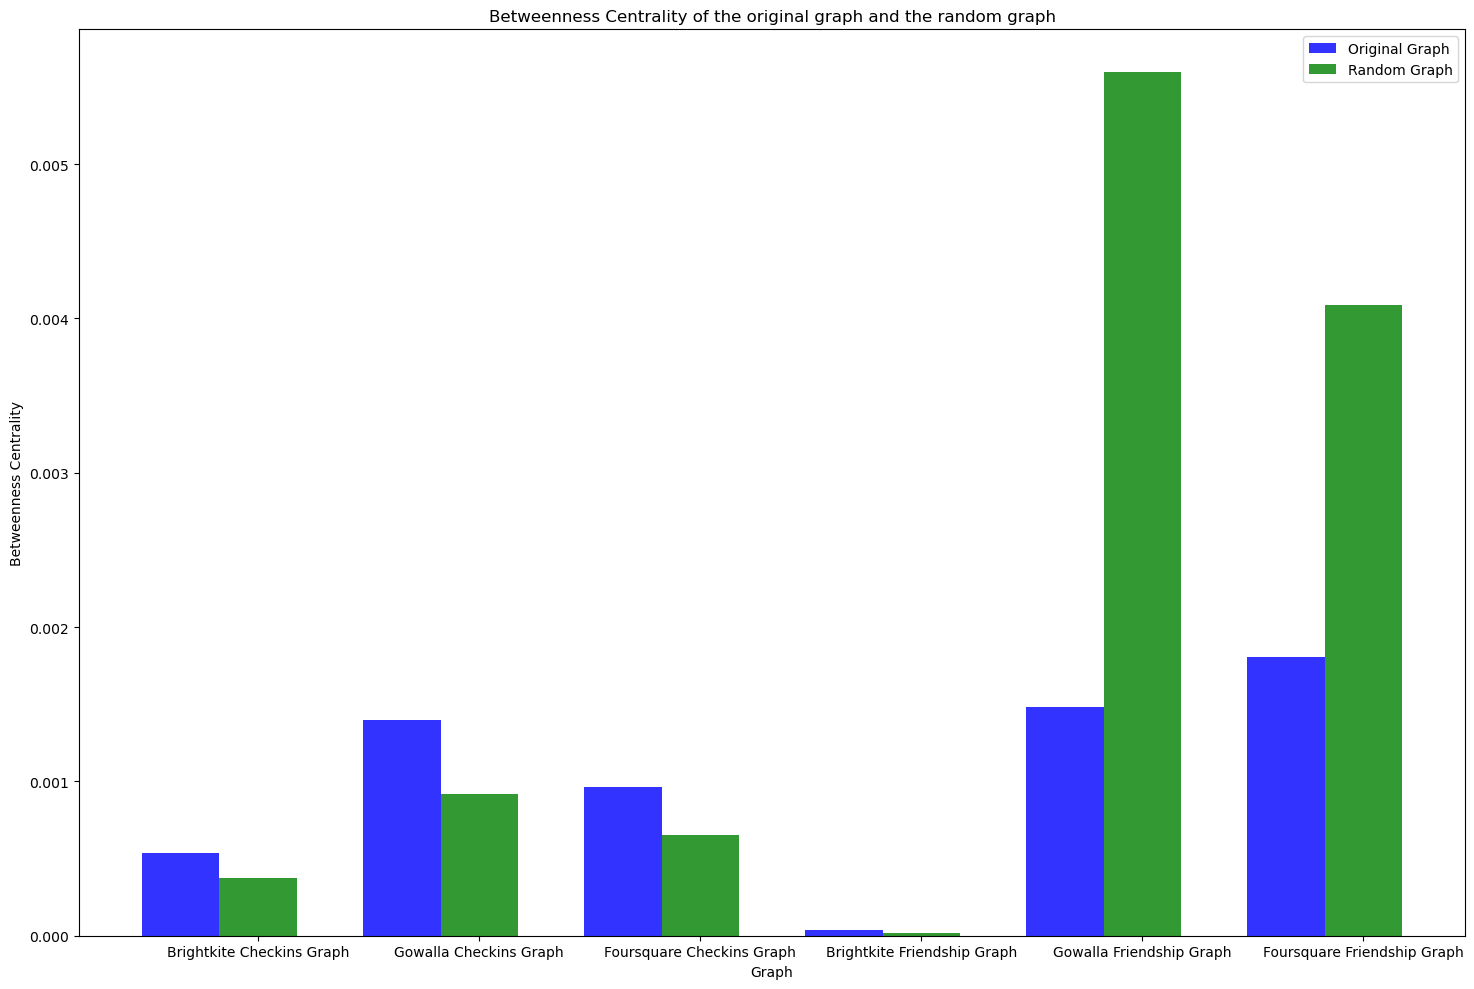

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
index = np.arange(len(random_graphs))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, analysis_results['betweenness centrality'], bar_width,
alpha=opacity,
color='b',
label='Original Graph')

rects2 = plt.bar(index + bar_width, random_graphs.values(), bar_width,
alpha=opacity,
color='g',
label='Random Graph')

plt.xlabel('Graph')
plt.ylabel('Betweenness Centrality')
plt.title('Betweenness Centrality of the original graph and the random graph')
plt.xticks(index + bar_width, random_graphs.keys())
plt.legend()

plt.tight_layout()
plt.show()

We can observe a marked distinction between the betweenness centrality of the networks generated from checkins and the networks generated from friendships. As the values of the betweenness centrality of the networks generated from checkins surpass the theoretical values of a random network, we can deduce that these networks generated from checkins exhibit a higher probability of being a small-world network. Conversely, the networks generated from friendships display a lower value of betweenness centrality than the theoretical values of a random network, thus indicating a lower likelihood of being a small-world network.

This property is consistent across both the Erdös-Rényi and Watts-Strogatz models.

## <a id='toc5_8_'></a>[Clustering coefficient](#toc0_)

The simplest `[5]` analytical treatment of clustering in a small-world network involves the use of the link addition model, as opposed to the rewiring model. As the network size $N$ approaches infinity and the fraction of shortcuts $\phi$ remains fixed, the probability of forming a triangle vanishes and the contribution of shortcuts to the clustering becomes negligible. As a result, the clustering of a small-world network is determined by its underlying ordered lattice.

As an example, consider a ring network where each node is connected to its $k$ closest neighbors on each side. The number of neighbors for a node is $2k$, resulting in $k(2k-1)$ pairs of neighbors. If we consider a node $i$, the $k$ nearest nodes on $i$'s left are connected to each other, as are the nodes on $i$'s right. This results in $k(k-1)$ pairs. If we consider a node located $d$ places to the left of node $i$, it will be connected to $k-d$ neighbors on $i$'s right side. The total number of connected neighbor pairs is $\frac{3}{2} k (k-1)$.

Therefore, the clustering coefficient $C$ can be calculated as follows:

$$ C = \frac{\frac{3}{2}k(k-1)}{k(2k-1)} =\frac{3 (k-1)}{2(2k-1)} $$

For all values of $k > 1$, this results in a constant larger than $0$, indicating that the clustering of a small-world network does not vanish for large networks. For large values of $k$, the clustering coefficient approaches $\frac{3}{4}$, signifying a very high clustering. It is important to note that for a regular two-dimensional grid, the clustering is defined as zero, since no triangles exist. However, the grid still has a neighborhood structure. `[2]`

---

We can compare the results of the clustering coefficient obtained through the standard formula and the formula derived above by utilizing the function `generalized_average_clustering_coefficient` in the `utils` module. This function takes a networkx graph object as input and returns the average clustering coefficient of the graph as a float.

In [30]:
generalized_cc = {}
for graph in graphs_all:
    generalized_cc[graph.name] = generalized_average_clustering_coefficient(graph)

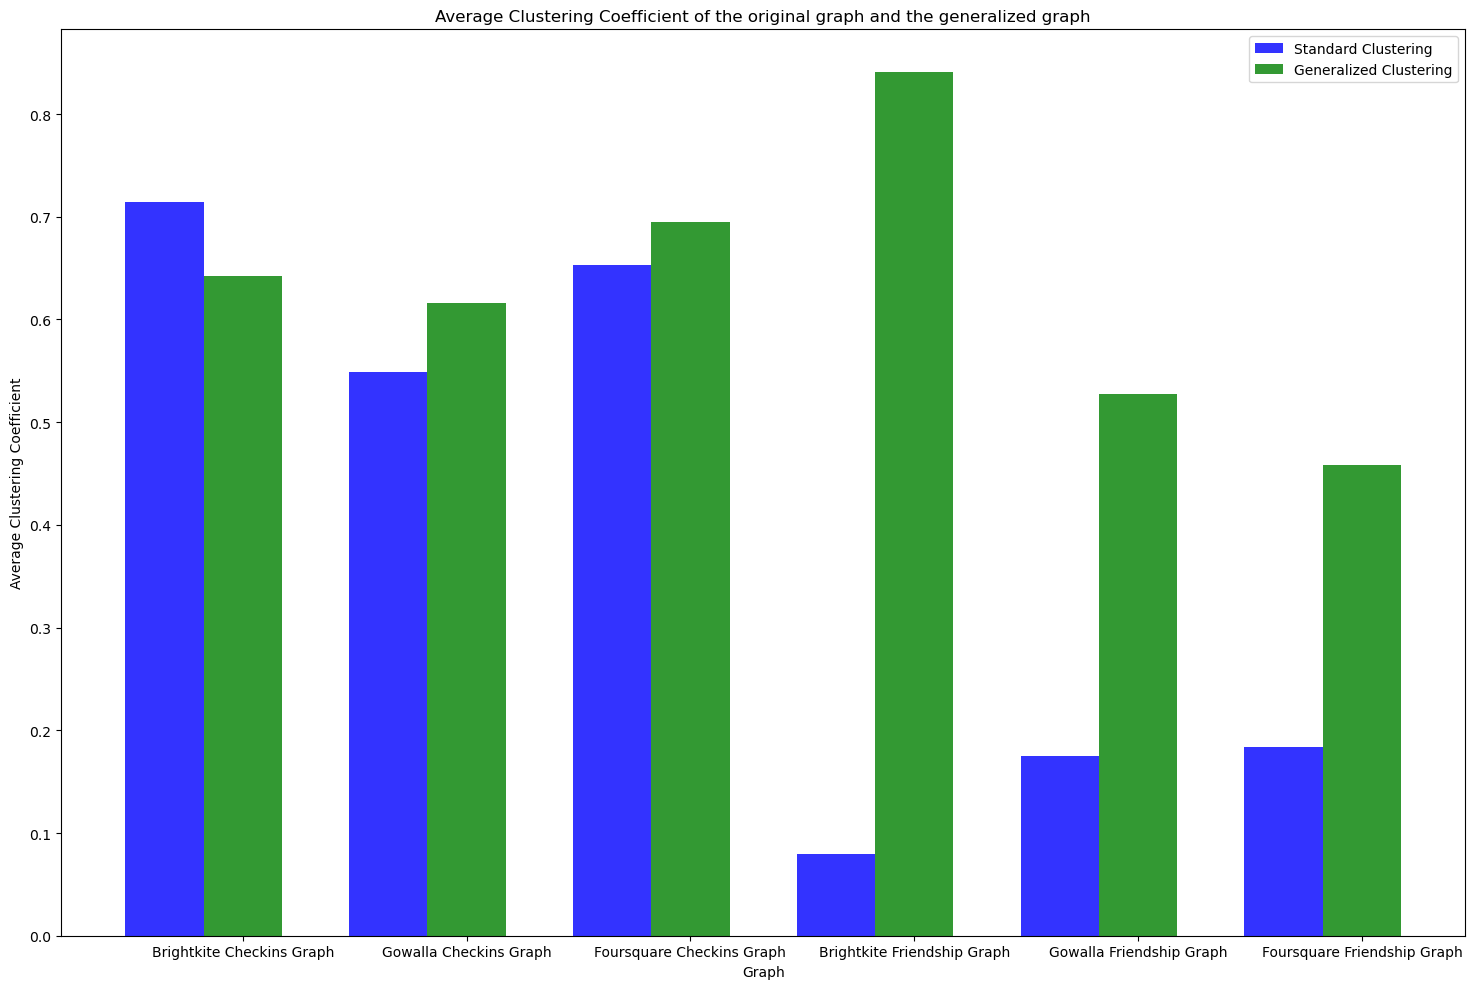

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
index = np.arange(len(generalized_cc))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, analysis_results['Average Clustering Coefficient'], bar_width,
alpha=opacity,
color='b',
label='Standard Clustering')

rects2 = plt.bar(index + bar_width, generalized_cc.values(), bar_width,
alpha=opacity,
color='g',
label='Generalized Clustering')

plt.xlabel('Graph')
plt.ylabel('Average Clustering Coefficient')
plt.title('Average Clustering Coefficient of the original graph and the generalized graph')
plt.xticks(index + bar_width, generalized_cc.keys())
plt.legend()

plt.tight_layout()
plt.show()

As evident, for the graphs derived from the checkins, the two values are nearly identical. On the other end, for the graphs derived from the friendships, the values differ significantly. This serves as further evidence that the checkins graphs exhibit a high likelihood of being a small-world network, compared to the friendships graphs.

However, this alone is insufficient to arrive at a definitive conclusion.

## <a id='toc5_9_'></a>[Conclusions: the omega coefficient](#toc0_)

We have already discussed a lot in the previous sections about this measure, let's see the results that we obtained after days of computations on the server:

In [32]:
analysis_results[['Graph', 'omega-coefficient']]

Graph  omega-coefficient
0    Brightkite Checkins Graph              -0.25
1       Gowalla Checkins Graph              -0.20
2    Foursquare Checkins Graph              -0.17
3  Brightkite Friendship Graph              -0.18
4     Gowalla Friendship Graph              -0.24
5  Foursquare Friendship Graph              -0.05

In order to illustrate the time-intensity of the Omega Coefficient computation, let's present the computation time for the networks generated from all networks. This results are obtained by running the `omega_sampled_server.py` function with `niter` and `nrand` equal to 3. Take into account that this is _not_ the parallelized version!

<!-- create a table -->

| Network | Time |
|:-------:|:----:|
| Brightkite Checkins | 9d 11h 25m |
| Gowalla Checkins | 3d 2h 55m |
| FourSquare Checkins | 6d 14h 13m |
| Brightkite Friendships | 17h 55m |
| Gowalla Friendships | 2h 22m |
| FourSquare Friendships | 2h 9m |

It is noteworthy that, due to the compact size of the friendship graphs, I successfully calculated the Omega Coefficient for the entire networks. On the other hand, for the checkins graphs, I resorted to a 50% sample of the nodes. 

---

The results of the Omega Coefficient computation are somewhat surprising. As stated previously the small-world coefficient (Omega) assesses the extent to which a network resembles a lattice or a random graph. Negative values indicate that the graph is similar to a lattice, while positive values suggest that the graph is more random-like. Values close to 0 should represent small-world characteristics.

Based solely on this metric, one may infer that all the studied networks exhibit small-world characteristics. In fact, all the values of the omega coefficient are approximately $0.2$ (with the exception of the Foursquare Checkins graph, whose value is very close to 0). Nonetheless, this conclusion requires further scrutiny.

As demonstrated in the preceding section, the Omega Coefficient can be misleading for networks with low clustering coefficients. In this case, the networks generated from friendships exhibit a low clustering coefficient and, as a result, bias the Omega Coefficient. This hypothesis of mine is reinforced by the results of other measures such as the Betweenness Centrality and the Clustering Coefficient, which suggest that the networks generated from friendships are not small-world networks.

Moreover, the graphs represent a social network in 2010, a time when social networks were not as prevalent as they are today. Hence, it is plausible that these networks are not small-worlds. I would have no problems believing that it's more likely to have visited the same place of a random person on the network, rather then being friends with them. This meaning that, heuristically, the networks generated from checkins are more likely to be small-worlds.

From a technical standpoint, using `niter` and `nrand` equal to 3 is insufficient to reach a definitive conclusion. However, increasing the values would have significantly prolonged the computation time of the Omega Coefficient and reducing the number of nodes in the sample would have reduced the accuracy of the results. So unfortunately, due to the time constraints, I was unable to test this hypothesis.


---

This study highlights the challenges in characterizing the small-world property of real-world networks. Despite utilizing established techniques, the results may still be inconclusive. In such cases, it is necessary to examine the specific properties of individual networks. This is exemplified by the Omega Coefficient, which can be influenced by unique characteristics of real-world networks, rendering the general results unreliable. In contrast, the results obtained from random networks are more predictable and reliable, as they do follow strict mathematical rules and have no unique characteristics determined by the real-world.

# <a id='toc6_'></a>[References](#toc0_)

> _In no particular order_

`[1]` On the evolution of random graphs, P. Erdős, A. Rényi, _Publ. Math. Inst. Hungar. Acad. Sci._, 5, 17-61 (1960).

`[2]` Complex Networks: Structure, Robustness, and Function, R. Cohen, S. Havlin, D. ben-Avraham, H. E. Stanley, _Cambridge University Press, 2009_.

`[3]` Collective dynamics of 'small-world' networks, D. J. Watts and S. H. Strogatz, _Nature_, 393, 440-442, 1998.

`[4]` On random graphs I, P. Erdős and A. Rényi, _Publ. Math. Inst. Hungar. Acad. Sci._, 5, 290-297, 1960.

`[5]` Generalizations of the clustering coefficient to weighted complex networks, M. E. J. Newman, _Physical Review E_, 74, 036104, 2006.

`[6]` The ubiquity of small-world networks. Telesford QK, Joyce KE, Hayasaka S, Burdette JH, Laurienti PJ. _Brain Connect_. 2011;1(5):367-75

`[8]` Humphries and Gurney (2008). “Network ‘Small-World-Ness’: A Quantitative Method for Determining Canonical Network Equivalence”. PLoS One. 3 (4)

`[9]` The brainstem reticular formation is a small-world, not scale-free, network M. D. Humphries, K. Gurney and T. J. Prescott, Proc. Roy. Soc. B 2006 273, 503-511,

`[10]` Sporns, Olaf, and Jonathan D. Zwi. “The small world of the cerebral cortex.” Neuroinformatics 2.2 (2004): 145-162.

`[11]` Maslov, Sergei, and Kim Sneppen. “Specificity and stability in topology of protein networks.” Science 296.5569 (2002): 910-913.

`[13]` B. Bollob ́as, Random Graphs, 1985. London: Academic Press

`[14]` R. Cohen, K. Erez, D. ben-Avraham, and S. Havlin, Resilience of the Internet to
random breakdown, Physical Review Letters 85 (2000), 4626–4628 

`[15]` Dingqi Yang, Bingqing Qu, Jie Yang, Philippe Cudre-Mauroux, Revisiting User Mobility and Social Relationships in LBSNs: A Hypergraph Embedding Approach, In Proc. of The Web  Conference (WWW'19). May. 2019, San Francisco, USA.

`[16]` Ulrik Brandes, A Faster Algorithm for Betweenness Centrality, Journal of Mathematical Sociology, 25(2):163-177, 2001._

`[17]` Error and attack tolerance of complex networks, R. Albert, Nature volume 406, pages378–382 (2000) 

<!-- `[18]` Boldi, Paolo, and Sebastiano Vigna. "Axioms for Centrality." ArXiv, (2013). -->


